In [1]:
import re
import torch
import jieba
import seaborn
import requests
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from wordcloud import WordCloud
from collections import Counter
from torchvision import transforms
from gensim import corpora, models
from torch.utils.data import DataLoader,Dataset
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_curve,auc,precision_recall_curve

ModuleNotFoundError: No module named 'numpy'

In [ ]:
#数据处理:先对数据进行清洗，用re表达式和stopwords去停用词。之后把图片爬下来保存。
#把csv文件中需要的列转为txt文件，之后用数据生成器技术进一步处理。
#文本：把txt文件划分为三个列表，用第一个列表sentence构建一个词汇到索引的映射表，在讲词汇转换为索引
#图片：利用torchvision模块统一尺寸，归一化处理。

def remove_stopwords(sentence,stop_words):
    """
    对数据进行清晰，利用re正则表达式去除没用的词，然后利用stopwords去停用词
    :param sentence:
    :param stop_words:
    :return:
    """
    sentence="".join(re.findall("[\u4e00-\u9fa5，。：！？ ,0-9]+",str(sentence)))
    for word in stop_words:
        sentence=sentence.replace(word,"")

    return sentence


def save_images(url,img_save_path):
    """
    网络请求，获取图片并进行保存
    :param url:
    :param img_save_path:
    :return:
    """
    res=requests.get(url,timeout=5)
    with open(img_save_path,"wb") as f:
        f.write(res.content)

def get_datasets():
    """
    获取数据txt文件，保存在datasets/train.txt中，第一行是标题和内容，第二行是图片地址，第三行是标签
    :return:
    """
    with open("WeFEND-AAAI20-master数据集/stopwords.txt","r",encoding="utf-8") as f:
        stop_words=f.read().split("\n")
    for train_or_test in ["train","test"][1:]:
        with open(f"datasets/{train_or_test}.txt","a",encoding="utf-8") as f:
            data=pd.read_csv(f"WeFEND-AAAI20-master数据集/data/{train_or_test}/news.csv")
            titles=data["Title"].values.tolist()
            img_urls=data["Image Url"].values.tolist()
            contents=data["Report Content"].values.tolist()
            labels=data["label"].values.tolist()
            for i in tqdm(range(len(data))):
                content=remove_stopwords(titles[i]+contents[i],stop_words)
                img_save_path=f"images/{train_or_test}/{i}.jpg"
                try:
                    save_images(url=img_urls[i],img_save_path=img_save_path)
                    f.write(content+"\t"+img_save_path+"\t"+str(labels[i])+"\n")
                except Exception as e:
                    print(e)
                    continue


In [ ]:
get_datasets()

 97%|█████████▋| 9825/10141 [11:53<05:09,  1.02it/s]

HTTPSConnectionPool(host='mmbiz.qlogo.cn', port=443): Read timed out. (read timeout=5)


100%|██████████| 10141/10141 [12:11<00:00, 13.86it/s]


In [ ]:
def get_word2index_dict():
    """
    获取字典，构建词汇到索引的映射表
    :return:
    """
    word_count=Counter()
    with open("datasets/train.txt","r",encoding="utf-8") as f:
        for line in f.readlines():
            line_split=line.strip().split("\t")
            sentence=line_split[0]
            for word in sentence:
                word_count[word]+=1

    most_common=word_count.most_common(4000)
    word2index_dict={word:index+2 for index,(word,count) in enumerate(most_common)}
    word2index_dict["PAD"]=0  # 填充
    word2index_dict["UNK"]=1  # 陌生字符

    return word2index_dict

class DataGenerator(Dataset):
    """
    数据生成器技术，可并行
    """

    def __init__(self,root,word2index_dict,max_len):        #处理图片，统一尺寸，归一化处理
        super(DataGenerator, self).__init__()
        self.root=root
        self.max_len=max_len
        self.word2index_dict=word2index_dict
        self.transforms=transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])  
        self.sentences,self.image_paths,self.labels=self.get_datasets()

    def __getitem__(self, item):        #将词汇转为索引
        image=Image.open(self.image_paths[item]).convert("RGB")
        token=[self.word2index_dict.get(w,1) for w in self.sentences[item]]
        if len(token)<self.max_len:             # 小于长度填充，大于截断
            token+=[0]*(self.max_len-len(token))
        else:
            token=token[:self.max_len]

        return torch.FloatTensor(self.transforms(image)),torch.LongTensor(token),torch.from_numpy(np.array(self.labels[item])).long()


    def __len__(self):
        return len(self.labels)

    def get_datasets(self):     #将dataset中数据进行分割，分割为三个列表，分别保存title，图像路径和标签
        sentences,image_paths,labels=[],[],[]
        with open(self.root,"r",encoding="utf-8") as f:
            for line in f.readlines():
                line_split=line.strip().split("\t")
                sentences.append(line_split[0])
                image_paths.append(line_split[1])
                labels.append(int(line_split[-1]))

        return sentences,image_paths,labels


class CnnLstmModel(nn.Module):
    """
    网络结构，图像部分用cnn提取特征，文字部分用LSTM提取特征
    """
    def __init__(self,num_vocabulary,num_classes):
        super(CnnLstmModel, self).__init__()
        self.embedding=nn.Embedding(num_embeddings=num_vocabulary,embedding_dim=128)
        
        self.lstm=nn.LSTM(input_size=128,hidden_size=256,bidirectional=True,batch_first=True) #LSTM
        
        self.conv1=nn.Sequential(                                                               #CNN
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        #全连接层
        self.fc1=nn.Linear(512,128)
        self.fc2=nn.Linear(576,128)
        self.fc=nn.Sequential(
            nn.Linear(256,64),
            nn.LeakyReLU(),
            nn.Linear(64,num_classes)
        )

    def forward(self,image,sentence):
        out1=self.embedding(sentence)
        _,(h,c)=self.lstm(out1)
        out1=torch.cat([h[0,:,:],h[1,:,:]],dim=-1)  # batch_size,512
        out1=self.fc1(out1)
        out2=self.conv1(image)
        out2=out2.view(out2.size(0),-1)
        out2=self.fc2(out2)

        out=torch.cat([out1,out2],dim=-1)
        return self.fc(out)

In [ ]:
def train():
    """
    对数据进行训练
    :return:
    """
    device=torch.device("cuda")
    word2index_dict=get_word2index_dict()
    model=CnnLstmModel(num_vocabulary=len(word2index_dict),num_classes=2).to(device)

    
    optimizer=optim.Adam(model.parameters(),lr=1e-3)                        # Adam优化器
    scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.9)    # 学习率调整策列，每五个epoch×0.9
    train_loader=DataLoader(DataGenerator(root="datasets/train.txt",word2index_dict=word2index_dict,max_len=150),batch_size=16,shuffle=True)  # 数据生成器输入数据
    val_loader=DataLoader(DataGenerator(root="datasets/test.txt",word2index_dict=word2index_dict,max_len=150),batch_size=16,shuffle=False)
    loss_func=nn.CrossEntropyLoss()                             # 损失函数
    train_accs,train_losses,val_accs,val_losses=[],[],[],[]
    max_acc=0
    for epoch in range(10):
        train_loss,train_acc=train_one_epoch(model,train_loader,loss_func,optimizer,scheduler,device,epoch)  # 训练一轮得到损失和准确率
        val_loss,val_acc=get_val_result(model,val_loader,loss_func,device)
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        print(f"epoch:{epoch+1},train acc:{train_acc},train loss:{train_loss},val acc:{val_acc},val_loss:{val_loss}")
        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(),f"models/cnn_lstm_epoch{epoch+1}.pth")  # 每10轮保存模型
        if max_acc<val_acc:
            max_acc=val_acc
            torch.save(model.state_dict(),"models/cnn_lstm_best.pth")  # 保存最优模型


def train_one_epoch(model,train_loader,loss_func,optimimer,scheduler,device,epoch):
    model.train()
    data=tqdm(train_loader)
    labels_true,labels_pred,losses=np.array([]),np.array([]),[]
    for batch,(x,y,z) in enumerate(data):
        labels_true=np.concatenate([labels_true,z.numpy()],axis=-1)
        x,y,z=x.to(device),y.to(device),z.to(device)
        y_prob=model(x,y)
        loss=loss_func(y_prob,z)
        losses.append(loss.item())
        y_pred=torch.argmax(y_prob,dim=-1).cpu().numpy()  # 预测值
        labels_pred=np.concatenate([labels_pred,y_pred],axis=-1)
        optimimer.zero_grad()  # 梯度清空
        loss.backward()  # 反向传播
        optimimer.step()  # 参数更新
        data.set_description_str(f"epoch:{epoch+1},batch:{batch+1},loss:{loss.item()},lr:{scheduler.get_last_lr()[0]}")

    scheduler.step()
    accuracy=accuracy_score(labels_true,labels_pred)

    return float(np.mean(losses)),accuracy

def get_val_result(model,val_loader,loss_func,device):
    """
    得到验证集的准确率及损失
    :param model:
    :param val_loader:
    :param loss_func:
    :param device:
    :return:
    """
    model.eval()
    data=tqdm(val_loader)                   #迭代显示进度条
    labels_true,labels_pred,losses=np.array([]),np.array([]),[]
    with torch.no_grad():
        for batch,(x,y,z) in enumerate(data):
            labels_true=np.concatenate([labels_true,z.numpy()],axis=-1)
            x,y,z=x.to(device),y.to(device),z.to(device)
            y_prob=model(x,y)                   #模型前向传播
            loss=loss_func(y_prob,z)
            losses.append(loss.item())
            y_pred=torch.argmax(y_prob,dim=-1).cpu().numpy()
            labels_pred=np.concatenate([labels_pred,y_pred],axis=-1)

    accuracy=accuracy_score(labels_true,labels_pred)            #计算准确率
    return float(np.mean(losses)),accuracy

def plot_acc_loss(train_accs,train_losses,val_accs,val_losses):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(range(1,len(train_accs)+1),train_accs,"r",label="train acc")
    plt.plot(range(1,len(val_accs)+1),val_accs,"g",label="val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1,len(train_losses)+1),train_losses,"r",label="train loss")
    plt.plot(range(1,len(val_losses)+1),val_losses,"g",label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.savefig("plots/epoch_loss_acc.jpg")

In [ ]:
train()

epoch:1,batch:659,loss:0.03454701229929924,lr:0.001: 100%|██████████| 659/659 [00:57<00:00, 11.44it/s]  
100%|██████████| 634/634 [00:53<00:00, 11.88it/s]


epoch:1,train acc:0.9077112776249644,train loss:0.24865990675341376,val acc:0.8757396449704142,val_loss:0.3286149682306717


epoch:2,batch:659,loss:0.02118416503071785,lr:0.001: 100%|██████████| 659/659 [00:59<00:00, 11.17it/s]  
100%|██████████| 634/634 [00:53<00:00, 11.90it/s]


epoch:2,train acc:0.9600682917575643,train loss:0.11892709031783055,val acc:0.8995069033530572,val_loss:0.4308992408198372


epoch:3,batch:659,loss:0.02328089065849781,lr:0.001: 100%|██████████| 659/659 [00:59<00:00, 11.14it/s]  
100%|██████████| 634/634 [00:53<00:00, 11.80it/s]


epoch:3,train acc:0.9742957412501185,train loss:0.07009899376567658,val acc:0.9007889546351084,val_loss:0.47547136690957037


epoch:4,batch:659,loss:0.09129675477743149,lr:0.001: 100%|██████████| 659/659 [00:57<00:00, 11.44it/s]   
100%|██████████| 634/634 [00:57<00:00, 10.95it/s]


epoch:4,train acc:0.9833064592620696,train loss:0.04173498699194103,val acc:0.8937869822485207,val_loss:0.4983880433913784


epoch:5,batch:659,loss:0.007135177496820688,lr:0.001: 100%|██████████| 659/659 [01:05<00:00, 10.13it/s]  
100%|██████████| 634/634 [00:57<00:00, 11.00it/s]


epoch:5,train acc:0.9877643934364033,train loss:0.027608582813138185,val acc:0.9029585798816568,val_loss:0.5775122117544755


epoch:6,batch:659,loss:0.0014480396639555693,lr:0.0009000000000000001: 100%|██████████| 659/659 [01:04<00:00, 10.19it/s] 
100%|██████████| 634/634 [00:56<00:00, 11.14it/s]


epoch:6,train acc:0.9890922887223751,train loss:0.030021507374795586,val acc:0.8986193293885602,val_loss:0.49357916813961694


epoch:7,batch:659,loss:0.0004941708757542074,lr:0.0009000000000000001: 100%|██████████| 659/659 [01:04<00:00, 10.27it/s] 
100%|██████████| 634/634 [00:52<00:00, 12.16it/s]


epoch:7,train acc:0.992222327610737,train loss:0.014373581924110769,val acc:0.9044378698224852,val_loss:0.7533389815895085


epoch:8,batch:659,loss:0.005030740983784199,lr:0.0009000000000000001: 100%|██████████| 659/659 [00:58<00:00, 11.36it/s]  
100%|██████████| 634/634 [00:52<00:00, 12.11it/s]


epoch:8,train acc:0.994403869866262,train loss:0.01295231525404701,val acc:0.9035502958579882,val_loss:0.727263396882542


epoch:9,batch:659,loss:0.0003400808200240135,lr:0.0009000000000000001: 100%|██████████| 659/659 [00:58<00:00, 11.19it/s] 
100%|██████████| 634/634 [00:53<00:00, 11.95it/s]


epoch:9,train acc:0.9909892819880489,train loss:0.026575405740081784,val acc:0.9063116370808678,val_loss:0.5482239948922297


epoch:10,batch:659,loss:0.0324602909386158,lr:0.0009000000000000001: 100%|██████████| 659/659 [00:57<00:00, 11.36it/s]    
100%|██████████| 634/634 [00:56<00:00, 11.13it/s]


epoch:10,train acc:0.9941193208764109,train loss:0.015275688058231597,val acc:0.9083826429980276,val_loss:0.6826474900924947


epoch:11,batch:46,loss:4.9566577217774466e-05,lr:0.0008100000000000001:   7%|▋         | 46/659 [00:04<00:56, 10.78it/s]


KeyboardInterrupt: 

In [ ]:
def get_test_result(model_path):
    """
    得到测试集评价指标
    :param model_path:
    :return:
    """
    device=torch.device("cuda")
    word2index_dict=get_word2index_dict()
    model=CnnLstmModel(num_vocabulary=len(word2index_dict),num_classes=2)
    model.load_state_dict(torch.load(model_path,map_location=device))
    model=model.to(device)
    model.eval()  # 加载模型
    test_loader=DataLoader(DataGenerator(root="datasets/test.txt",word2index_dict=word2index_dict,max_len=150),batch_size=16,shuffle=False)
    labels_true,labels_pred,labels_prob=np.array([]),np.array([]),[]
    data=tqdm(test_loader)
    with torch.no_grad():
        for batch,(x,y,z) in enumerate(data):
            labels_true=np.concatenate([labels_true,z.numpy()],axis=-1)
            x,y,z=x.to(device),y.to(device),z.to(device)
            y_prob=model(x,y)
            labels_prob.append(y_prob.cpu().numpy())
            y_pred=torch.argmax(y_prob,dim=-1).cpu().numpy()
            labels_pred=np.concatenate([labels_pred,y_pred],axis=-1)

    labels_prob=np.concatenate(labels_prob,axis=0)
    # 评价指标
    accuracy=accuracy_score(labels_true,labels_pred)
    precision=precision_score(labels_true,labels_pred)
    recall=recall_score(labels_true,labels_pred)
    f1=f1_score(labels_true,labels_pred)

    print(f"accuracy:{accuracy},precision:{precision},recall:{recall},f1:{f1}")
    # ROC曲线
    plt.figure(figsize=(8,8))
    fpr,tpr,_=roc_curve(labels_true,labels_prob[:,-1])
    plt.plot([0,1],[0,1],"r--")
    plt.plot(fpr,tpr,"g",label=f"AUC:{auc(fpr,tpr):.3f}")
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.savefig("plots/roc_curve.jpg")
    # PR曲线
    plt.figure(figsize=(8,8))
    p,r,_=precision_recall_curve(labels_true,labels_prob[:,-1])
    plt.plot([0,1],[1,0],"r--")
    plt.plot(p,r,"g")
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.savefig("plots/pr_curve.jpg")
    # 混淆矩阵
    plt.figure(figsize=(5,5))
    matrix=pd.DataFrame(confusion_matrix(labels_true,labels_pred,normalize="true"),index=["Fake","True"],columns=["Fake","True"])
    seaborn.heatmap(matrix,annot=True,cmap="GnBu")
    plt.savefig("plots/confusion_matrix.jpg")

100%|██████████| 634/634 [00:52<00:00, 12.06it/s]


accuracy:0.9083826429980276,precision:0.764367816091954,recall:0.5388251181634031,f1:0.632079207920792


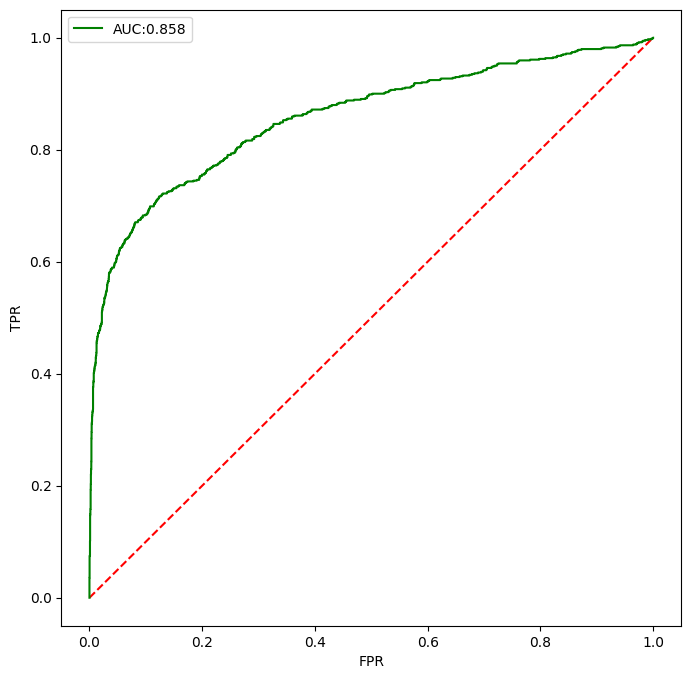

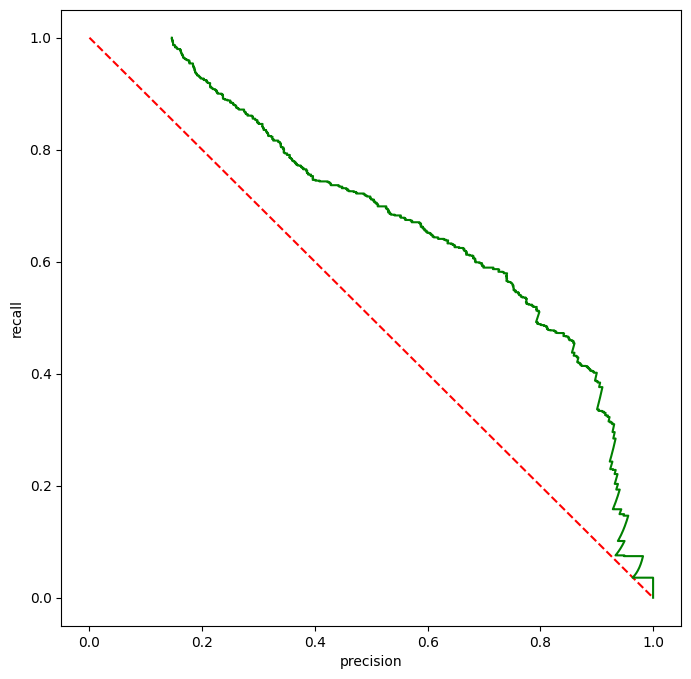

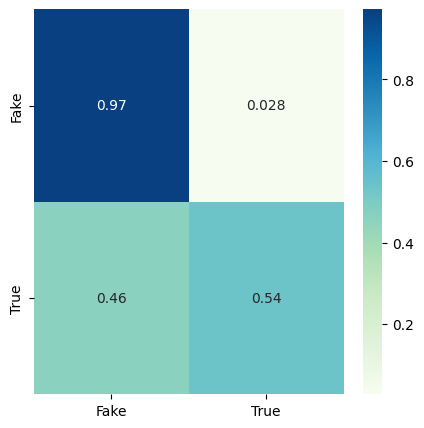

In [ ]:
get_test_result(model_path="models/cnn_lstm_best.pth")

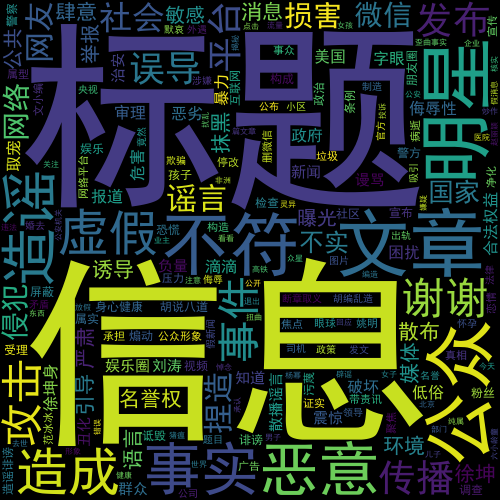

In [ ]:
# 关键词分析，用词云图进行展示
counter=Counter()
data_new=pd.read_csv("datasets/train.txt",sep="\t",header=None)
for sentence in data_new.iloc[:,0].values.tolist():  # 遍历每个内容
    for word in jieba.lcut(sentence):
        if len(word)>1:
            counter[word]+=1

most_common=counter.most_common(1000)  # 取出最常见的1000个词
key_words=[item[0] for item in most_common]
wc=WordCloud(width=500,height=500,font_path="WeFEND-AAAI20-master数据集/simhei.ttf")
wc.generate(",".join(key_words))
image_wc=wc.to_image()
image_wc.save("plots/词云图.jpg")
image_wc

In [ ]:
# LDA主题建模
def seg_to_list(s):

    return [w for w in jieba.lcut(s) if len(w)>1]

# 数据加载
def load_data(ss):
    doc_list = []
    for s in ss:
        content = "".join(re.findall("[\u4E00-\u9FA5，。！]",s))
        seg_list = seg_to_list(content)
        doc_list.append(seg_list)
    return doc_list

In [ ]:
sentences=data_new.iloc[:,0].values.tolist()
sentences_list=load_data(sentences)
print(sentences_list[:10])

[['反腐', '风刮', '根廷', '瘫痪', '总统', '子摊', '不符'], ['道歉', '部亿剧映', '网友', '狂吐槽', '拍成', '村头', '恋曲', '满口胡'], ['风车', '司机', '奸杀', '女客', '落网', '视频', '曝光', '滴滴', '道歉'], ['偶遇', '鹿晗', '关晓彤', '旅行', '七夕', '情侣', '真滴', '领屁', '证妹', '七夕', '今天', '眼球'], ['赵丽颖', '冯绍峰', '公布', '恋情', '网友', '曝不', '曝没区', '事件'], ['强制', '堕胎', '强制', '交配', '消息', '强制', '生育'], ['不忍', '直视', '外面', '杭州', '公寓', '水帘洞', '墙角', '缝隙', '长出', '蘑菇', '无证', '说明', '投诉', '诱导', '读行'], ['五部委', '喊话', '投案', '处罚', '部委', '国务院', '机构', '称谓', '法检脱', '政府', '国家', '组成', '机构', '常识性', '错误'], ['迪士尼', '气球', '哄抢', '网友', '东方网', '记日', '报道', '昨天', '日海', '迪士尼', '乐园', '游客', '公然', '哄抢', '售卖', '气球', '东方网', '现场', '知情', '士处', '获悉', '事源场', '误会', '弄清', '原委', '游客', '气球'], ['甲醛', '超标', '房客', '生病', '租金', '封口']]


In [ ]:
dictionary = corpora.Dictionary(sentences_list)
dictionary.filter_n_most_frequent(200)
corpus = [dictionary.doc2bow(text) for text in sentences_list]
lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, minimum_probability=0.001)
topic_list=lda.print_topics(num_topics=5,num_words=15)  #
print(topic_list)

[(0, '0.011*"落泪" + 0.008*"关晓彤" + 0.007*"徐坤" + 0.007*"化妆品" + 0.006*"破坏" + 0.005*"困扰" + 0.005*"环境" + 0.004*"党不实" + 0.004*"鹿晗" + 0.004*"结婚" + 0.004*"合法权益" + 0.004*"出场" + 0.004*"危害" + 0.003*"严肃" + 0.003*"非诚"'), (1, '0.010*"郑爽" + 0.008*"马蓉" + 0.007*"冯小刚" + 0.006*"赵忠祥" + 0.006*"主持" + 0.006*"产品" + 0.004*"徐坤" + 0.003*"爷爷" + 0.003*"语言" + 0.003*"女友" + 0.003*"光洁" + 0.003*"侮辱性" + 0.003*"复婚" + 0.003*"热巴" + 0.003*"丑闻"'), (2, '0.015*"肆意" + 0.014*"建华" + 0.009*"公共" + 0.008*"散播谣言" + 0.008*"贾亮" + 0.007*"半夜" + 0.006*"董卿" + 0.006*"黄晓明" + 0.005*"构造" + 0.005*"文小编" + 0.005*"事众" + 0.005*"名誉权" + 0.005*"环境" + 0.005*"停改" + 0.005*"构成"'), (3, '0.009*"严肃" + 0.008*"决定" + 0.007*"心酸" + 0.007*"张杰" + 0.007*"小宝" + 0.006*"全场" + 0.006*"焦点" + 0.006*"聚焦" + 0.006*"王菲" + 0.006*"分手" + 0.005*"隐瞒" + 0.005*"审理" + 0.005*"结婚" + 0.005*"葬礼" + 0.005*"刘诗"'), (4, '0.010*"亲生" + 0.009*"婚变" + 0.008*"毕福剑" + 0.007*"周润发" + 0.005*"胡歌" + 0.005*"王思聪" + 0.005*"带娃" + 0.005*"抢救无效" + 0.005*"现身" + 0.004*"停工" + 0.004*"王凯" + 0.004*"女星" + 0.004*"星光" + 0.0

In [ ]:
total_data=[]
for item in topic_list:
    topic_id=item[0]
    words,weight=[],[]
    for line in item[1].replace(" ","").split("+"):
        line_split=line.split("*")
        words.append(line_split[1].replace('"',"").lower())
        weight.append(float(line_split[0]))
    total_data.append(np.expand_dims(words,axis=-1))
    total_data.append(np.expand_dims(weight,axis=-1))

total_data=pd.DataFrame(np.concatenate(total_data,axis=-1),columns=["topic1","权重","topic2","权重","topic3","权重","topic4","权重","topic5","权重"])
total_data.to_csv("topic.csv",index=False)
total_data  # 分出了5个主题，每个主题有关键词

,topic1,权重,topic2,权重,topic3,权重,topic4,权重,topic5,权重
0,落泪,0.011,郑爽,0.01,肆意,0.015,严肃,0.009,亲生,0.01
1,关晓彤,0.008,马蓉,0.008,建华,0.014,决定,0.008,婚变,0.009
2,徐坤,0.007,冯小刚,0.007,公共,0.009,心酸,0.007,毕福剑,0.008
3,化妆品,0.007,赵忠祥,0.006,散播谣言,0.008,张杰,0.007,周润发,0.007
4,破坏,0.006,主持,0.006,贾亮,0.008,小宝,0.007,胡歌,0.005
5,困扰,0.005,产品,0.006,半夜,0.007,全场,0.006,王思聪,0.005
6,环境,0.005,徐坤,0.004,董卿,0.006,焦点,0.006,带娃,0.005
7,党不实,0.004,爷爷,0.003,黄晓明,0.006,聚焦,0.006,抢救无效,0.005
8,鹿晗,0.004,语言,0.003,构造,0.005,王菲,0.006,现身,0.005
9,结婚,0.004,女友,0.003,文小编,0.005,分手,0.006,停工,0.004
